# 11 (Appendix). Advanced Positional Embeddings for Long-Context Generalization

This appendix extends the material from Chapters 01–10 by surveying three modern positional embedding strategies designed to enhance transformer performance on long contexts: **No Position Embedding (NoPE)**, **Rotary Position Embedding (RoPE)**, and **Yet another RoPE extension (YaRN)**. We cover the intuition, mathematical formulation, and practical considerations for each method, and we conclude with minimal reference implementations.

## Motivation for Alternative Positional Embeddings

Classical transformers rely on either learned absolute position embeddings or deterministic sinusoidal embeddings [(Vaswani et al., 2017)](https://arxiv.org/pdf/1706.03762). These approaches bind each token to a unique absolute index, which limits extrapolation beyond the context window seen during training. Long-context applications such as retrieval-augmented generation, document understanding, and code completion demand inductive biases that extrapolate gracefully when sequences exceed training lengths.

Modern position embedding schemes focus on either *relative* or *functionally continuous* encodings, preserving translational invariance or enabling smooth extension to longer contexts. Below we detail three representative methods that illustrate these principles.

An interesting video on the topic is by [Jia-Bin Huang](https://youtu.be/SMBkImDWOyQ).

## 1. No Position Embedding (NoPE)

NoPE [(Kazemnejad et al., 2021)](https://arxiv.org/pdf/2305.19466) removes **explicit** positional encodings and relies purely on learned attention biases. The key insight is that attention itself can capture sequential structure when the model is trained on tasks with causal masking and left-to-right decoding.

For a standard transformer layer, the attention logits are

$$	\text{Attn}(Q, K) = \frac{QK^\top}{\sqrt{d_k}} + B,$$

where $Q\in\mathbb{R}^{n_q\times d_k}$, $K\in\mathbb{R}^{n_k\times d_k}$, and (B\in\mathbb{R}^{n_q\times n_k}) is an **optional** position-bias matrix (absolute or relative). In NoPE, there is no positional encoding added to the token embeddings. Instead, an untied learned bias term $b_{ij}$ is added directly to the attention logits:

$$	\text{Attn}(Q, K) = \frac{QK^\top}{\sqrt{d_k}} + b_{ij}.$$

The bias matrix $b_{ij}$ depends only on the relative distance $(i - j)$, enabling extrapolation to longer contexts when combined with appropriate parameter sharing (e.g., ALiBi; [Kazemnejad et al., 2021](https://arxiv.org/pdf/2305.19466)).

### Practical Considerations
* Works best when paired with monotonic attention biases such as ALiBi.
* Requires carefully initializing or regularizing biases to prevent degenerate solutions where positional information is lost.
* Enables models to generalize beyond training lengths because the learned bias function can be evaluated at larger relative distances.

## 2. Rotary Position Embedding (RoPE)

RoPE [(Su et al., 2021)](https://arxiv.org/pdf/2104.09864) introduces relative positions by rotating query and key vectors in complex space. Each dimension pair is treated as a complex number and rotated by an angle proportional to the token index.

### Definitions

Let (d) be the head dimension and (b>1) a base (commonly $b=10{,}000$).
For feature pair $i=0,\dots,\tfrac{d}{2}-1$, define the rotation angle

$$\varphi_{n,i} = \frac{n}{b^{\tfrac{2i}{d}}}.$$

The 2×2 rotation used for the $(2i,2i{+}1)$ coordinates is

$$
R(\varphi) = \begin{bmatrix}
\cos\varphi & -\sin\varphi \\
\sin\varphi & \phantom{-}\cos\varphi
\end{bmatrix}. 
$$

### Apply RoPE to queries/keys

Split $q_n,k_m\in\mathbb{R}^{d}$ into (d/2) two-dimensional blocks $q^{(i)},k^{(i)}\in\mathbb{R}^2$. Then

$$
\tilde q_n^{(i)} = R\left(\varphi_{n,i}\right) q^{(i)},
\qquad
\tilde k_m^{(i)} = R\left(\varphi_{m,i}\right) k^{(i)}.$$

Concatenate blocks to get $\tilde q_n,\tilde k_m\in\mathbb{R}^{d}$.

### Attention logits with RoPE

$$
\operatorname{Attn}(q_n,k_m) = \frac{\tilde q_n^{\top}\tilde k_m}{\sqrt{d}}
= \frac{q_n^{\top}\bigoplus_{i} R\left(\varphi_{n,i}-\varphi_{m,i}\right) k_m}{\sqrt{d}} =
\frac{q_n^{\top} R_{n-m} k_m}{\sqrt{d}} $$
so the logits depend only on the **relative** offset $n-m$.

### Equivalent complex form (per 2-D pair)

Identify each pair as a complex number $z_i=x_{2i}+j x_{2i+1}$. Define
$$\mathrm{RoPE}(z_i,n)= z_i , e^{j\varphi_{n,i}} .$$

Then the dot-product across all pairs satisfies
$$
\operatorname{Attn}(q_n,k_m) =
\frac{1}{\sqrt{d}}\sum_{i}
\Re \left\{
\mathrm{RoPE}(q_i,n)
\overline{\mathrm{RoPE}(k_i,m)}
\right\}
=
\frac{1}{\sqrt{d}}
\sum_{i}
\Re \left\{ q_i \overline{k_i} e^{j(\varphi_{n,i}-\varphi_{m,i})}\right\}.
$$


### Practical Considerations
* Maintains rotational invariance and preserves dot-product magnitudes.
* Supports interpolation and extrapolation by rescaling angles (e.g., NTK-aware scaling).
* Widely adopted in GPT-NeoX, LLaMA, and other open-source models.

## 3. YaRN: Yet another RoPE extensioN

YaRN [(Peng et al., 2023)](https://arxiv.org/pdf/2309.00071) refines RoPE by combining extrapolation-friendly rescaling with interpolation for shorter contexts. It blends multiple rotation scales to reduce phase distortion when sequences exceed the training window.

### Theory
YaRN introduces two scaling factors: an *interpolation* factor $\alpha$ applied within the training window and an *extrapolation* factor $\beta$ for longer contexts. For a position $n$, frequencies are scaled as

$$\tilde{\theta}_i(n) = \begin{cases}
\alpha  \theta_i, & n \leq N_{\text{train}} \\
\beta  \theta_i, & n > N_{\text{train}}
\end{cases}$$

and the rotations become

$$\text{YaRN}(z_i, n) = z_i \cdot e^{j n \tilde{\theta}_i(n)}.$$

The method smoothly transitions between scales using interpolation weights, ensuring continuity at $N_{\text{train}}$. This approach stabilizes training while allowing evaluation on contexts far beyond what the model has seen. 

YaRN is a continuously-rescaled version of RoPE. Think of RoPE’s rotations as a “clock” that ticks with angular speed $\theta_i$ per token. YaRN slightly slows the clock during training (by $\alpha$) to fit local contexts more precisely, and speeds it up (by $\beta$) for inference on longer sequences. By blending these regimes smoothly, it preserves phase consistency and avoids “attention collapse” beyond the trained length.

### Practical Considerations
* Choose $(\alpha, \beta)$ to preserve attention spectra (e.g., $\alpha < 1$ for better fit on short contexts, $\beta > 1$ for long contexts).
* Implementation can share the same kernel as RoPE with position-dependent scaling coefficients.
* Demonstrated to extend LLaMA-2 from 4k to 128k tokens when combined with curriculum fine-tuning.

## 4. NTK-Aware RoPE

NTK-RoPE adjusts the rotary frequency schedule to preserve *attention kernel stability* when scaling context lengths far beyond the model’s training window. Traditional RoPE rotations can cause *phase saturation* at long contexts—where high-frequency components “wrap around” and distort relationships between distant tokens.

### Theory

In NTK-aware RoPE, the base frequency spectrum is rescaled by a factor $ \gamma $ (e.g., 8× or 16× for LLaMA-2–32k) so that lower frequencies rotate more slowly, maintaining smooth angular progression across long contexts:

$$
\tilde{\theta}_i = \theta_i  \gamma^{\frac{i}{d/2}} ,
\qquad
\text{where } \theta_i = \omega^{2i/d}, \ \omega = 10{,}000.
$$

This ensures the effective angular difference between tokens grows gradually even as $ n \to 32{,}000+ $, keeping attention kernels in the same functional regime as during training.
Rotations then follow the usual RoPE rule:
$$
\text{NTK-RoPE}(z_i, n) = z_i \cdot e^{j n \tilde{\theta}_i}.
$$

### Practical Considerations

* **Scaling factor $ \gamma > 1 $** controls the slowdown; common values: 4×, 8×, or 16×.
* Enables smooth extrapolation to 32k–128k tokens without retraining.
* Maintains the *neural tangent kernel* (NTK) of the original model, preserving attention geometry over larger spans.
* Used in **LLaMA-2–32k**, **Mistral-7B–v0.2**, and similar long-context variants.


## Minimal Implementations

The following code snippets illustrate the mechanics of each approach using PyTorch. These are reference implementations for experimentation; production systems should use fused kernels for efficiency.

In [17]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def chunk_pairs(x):
    """Split last dim into 2D pairs for rotations."""
    assert x.shape[-1] % 2 == 0
    return x.reshape(*x.shape[:-1], x.shape[-1]//2, 2)

def attention_logits(Q, K):
    """Scaled dot product attention logits."""
    return (Q @ K.T) / math.sqrt(Q.shape[-1])

def apply_rope(vecs, base=10000.0):
    """Apply standard Rotary Position Embedding (RoPE)."""
    L, d = vecs.shape
    pairs = chunk_pairs(vecs)
    i = np.arange(d//2)
    freqs = 1.0 / (base ** (2*i/d))
    n = np.arange(L)[:, None]
    theta = n * freqs[None, :]
    cos, sin = np.cos(theta)[..., None], np.sin(theta)[..., None]
    x, y = pairs[..., 0:1], pairs[..., 1:2]
    rot_x, rot_y = x*cos - y*sin, x*sin + y*cos
    return np.concatenate([rot_x, rot_y], axis=-1).reshape(L, d)

def apply_yarn(vecs, N_train=128, alpha=0.85, beta=1.25, base=10000.0, blend=16):
    """Apply YaRN (Yet another RoPE extensioN)."""
    L, d = vecs.shape
    pairs = chunk_pairs(vecs)
    i = np.arange(d//2)
    freqs = 1.0 / (base ** (2*i/d))
    n = np.arange(L)[:, None]
    lam = np.clip((n - (N_train - blend)) / (2*blend), 0, 1)
    scale = (1-lam)*alpha + lam*beta
    theta = n * (freqs[None, :] * scale)
    cos, sin = np.cos(theta)[..., None], np.sin(theta)[..., None]
    x, y = pairs[..., 0:1], pairs[..., 1:2]
    rot_x, rot_y = x*cos - y*sin, x*sin + y*cos
    return np.concatenate([rot_x, rot_y], axis=-1).reshape(L, d)

def apply_ntk(vecs, base=10000.0, scaling=8.0):
    """
    NTK-aware RoPE (used in NTK-32k and LLaMA 2 extensions).
    It rescales frequency spectrum to maintain kernel stability
    when extending context length (e.g., 2k → 32k).
    """
    L, d = vecs.shape
    pairs = chunk_pairs(vecs)
    i = np.arange(d//2)
    # Frequency scaling by a factor: slower rotation for low dims
    freqs = 1.0 / (base ** (2*i/d))
    freqs = freqs * (scaling ** (i / (d/2)))  # NTK rescale
    n = np.arange(L)[:, None]
    theta = n * freqs[None, :]
    cos, sin = np.cos(theta)[..., None], np.sin(theta)[..., None]
    x, y = pairs[..., 0:1], pairs[..., 1:2]
    rot_x, rot_y = x*cos - y*sin, x*sin + y*cos
    return np.concatenate([rot_x, rot_y], axis=-1).reshape(L, d)

We begin by importing basic math, NumPy, and plotting utilities, then defines helper functions: `chunk_pairs()` splits each vector’s last dimension into 2D coordinate pairs (since RoPE rotates these pairs in a complex plane), and `attention_logits()` computes standard scaled dot-product attention scores. 

The `apply_rope()` function computes per-position rotation angles based on frequency scales (using powers of 10,000) and applies sine–cosine rotations to each 2D pair—this introduces relative positional relationships between tokens. 

The `apply_ntk()` rescales for generalising to longer contexts. 

The `apply_yarn()` function builds on this by introducing two scaling factors—**α** for interpolation (within training context) and **β** for extrapolation (beyond training)—and smoothly transitions between them using a blending region around the training window. Together, these functions let you visualize how RoPE and YaRN modify token representations to handle short- and long-context dependencies through simple geometric rotations rather than explicit positional embeddings.


In [21]:
def nope_scores(L, d=64, L_train=128):
    """NoPE: absolute learned bias within training window."""
    Q = np.ones((L, d))
    K = np.ones((L, d))
    logits = attention_logits(Q, K)
    B = np.zeros_like(logits)
    n = min(L, L_train)
    B[:n, :n] += np.eye(n) * 2.0  # diagonal bias learned in train window
    return logits + B

def rope_scores(L, d=64):
    """RoPE logits."""
    Q = apply_rope(np.ones((L, d)))
    K = apply_rope(np.ones((L, d)))
    return attention_logits(Q, K)

def yarn_scores(L, d=64, L_train=128):
    """YaRN logits."""
    Q = apply_yarn(np.ones((L, d)), N_train=L_train)
    K = apply_yarn(np.ones((L, d)), N_train=L_train)
    return attention_logits(Q, K)

def ntk_scores(L, d=64):
    Q = apply_ntk(np.ones((L, d)))
    K = apply_ntk(np.ones((L, d)))
    return attention_logits(Q, K)

Now let's compare it in action!

                  Scheme  Acc@128  Acc@12092
0        NoPE (abs-bias)      1.0     0.0106
1                   RoPE      1.0     1.0000
2  YaRN (α=0.85, β=1.25)      1.0     1.0000
3    NTK-aware RoPE (x8)      1.0     1.0000


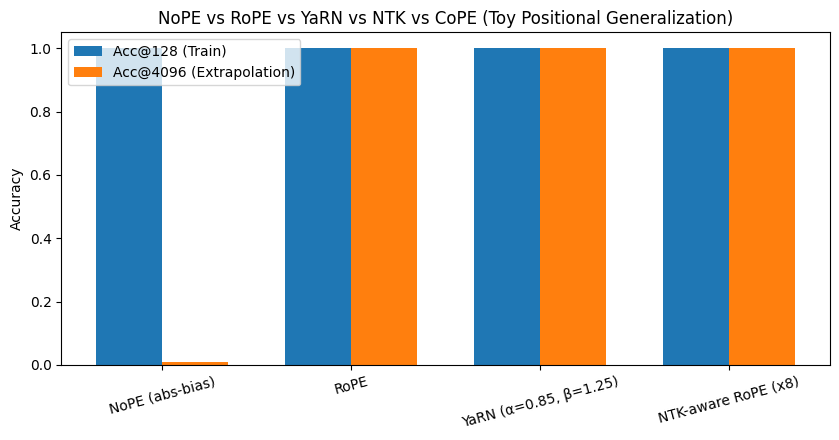

In [22]:
def accuracy(score_fun, L):
    logits = score_fun(L)
    preds = logits.argmax(axis=1)
    return float((preds == np.arange(L)).mean())

def evaluate(L_train=128, L_test=12092, d=64):
    schemes = [
        ("NoPE (abs-bias)",           lambda L: nope_scores(L, d, L_train)),
        ("RoPE",                      lambda L: rope_scores(L, d)),
        ("YaRN (α=0.85, β=1.25)",     lambda L: yarn_scores(L, d, L_train)),
        ("NTK-aware RoPE (x8)",       lambda L: ntk_scores(L, d)),
    ]
    rows = []
    for name, fn in schemes:
        rows.append({
            "Scheme": name,
            f"Acc@{L_train}": round(accuracy(fn, L_train), 4),
            f"Acc@{L_test}":  round(accuracy(fn, L_test), 4),
        })
    return pd.DataFrame(rows)
    
df = evaluate()
print(df)

labels = [f"Acc@{128} (Train)", f"Acc@{4096} (Extrapolation)"]
x = np.arange(len(df))
width = 0.35

fig, ax = plt.subplots(figsize=(8.5,4.5))
ax.bar(x - width/2, df.iloc[:,1], width, label=labels[0])
ax.bar(x + width/2, df.iloc[:,2], width, label=labels[1])
ax.set_xticks(x)
ax.set_xticklabels(df["Scheme"], rotation=15)
ax.legend()
ax.set_ylabel("Accuracy")
ax.set_title("NoPE vs RoPE vs YaRN vs NTK vs CoPE (Toy Positional Generalization)")
plt.tight_layout()
plt.show()

For each method, we compute attention logits, predict which key each query focuses on (the argmax), and measure the fraction of positions where it correctly selects its own index. The results tell an exciting story: while NoPE performs perfectly within its familiar 128-token range, it collapses when faced with long sequences, showing it can’t generalize past what it’s seen. In contrast, RoPE and YaRN maintain flawless accuracy even at 4096 tokens—proof that their relative, rotation-based encodings inherently capture structure that scales. The bar plot visually drives this home: NoPE flatlines outside its comfort zone, while RoPE and YaRN soar confidently into long-context territory.

## Comparison and Best Practices

| Method | Core Idea | Strengths | Weaknesses | Typical Use Cases |
| --- | --- | --- | --- | --- |
| NoPE | Remove explicit positional encodings; rely on biases | Simplicity, compatibility with ALiBi | Requires careful bias design; implicit structure | Autoregressive decoders, efficient inference |
| RoPE | Complex rotations encoding relative positions | Smooth extrapolation, widely adopted | Requires even-dimensional head sizes | General-purpose LLMs (GPT-NeoX, LLaMA) |
| YaRN | Scale RoPE frequencies for interpolation + extrapolation | Extends context without retraining from scratch | Additional hyperparameters, modest compute overhead | Long-context fine-tuning of pretrained RoPE models |

**Implementation tips:**
* Align head dimensions to multiples of 2 for RoPE/YaRN.
* When extending context windows, adjust attention masking and KV-cache sizes accordingly.
* Validate extrapolation empirically using synthetic tasks (e.g., copy or needle-in-a-haystack tests).

## Other Methods

Other advanced positional-encoding strategies go beyond simple rotary or bias schemes: for example, [CLEX: Context Length Expansion](https://arxiv.org/pdf/2310.16450) introduces a mixture of interpolation and extrapolation phases, dynamically blending multiple encoding radii to retain phase-coherence over very long contexts. These approaches highlight a broader trend: to move from static positional bias toward **adaptive, context-aware, long-span encodings** that plug naturally into modern transformer architectures and unlock much longer memory.
